In [1]:
import sys
sys.path.append('..')

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Objective
In this notebook, we will show how to evaluate the performance of a model on a test or validation set. 
This notebook assumes that the network has already been trained and saved.

# Input
1. data_dir: directory of the data. The datafile should be present in the data_dir.
2. ckpt_dir: directory of the checkpoint. The checkpoint file and config should be present in the ckpt_dir.

In [3]:
import random
import os
import numpy as np
import torch
import pickle
import ml_collections
import glob
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

from tqdm import tqdm
import numpy as np
from disentangle.training import create_dataset, create_model
import matplotlib.pyplot as plt
from disentangle.core.loss_type import LossType
from disentangle.config_utils import load_config
from disentangle.analysis.lvae_utils import get_img_from_forward_output
from disentangle.analysis.plot_utils import clean_ax
from disentangle.core.data_type import DataType
from disentangle.core.psnr import PSNR
from disentangle.analysis.plot_utils import get_k_largest_indices,plot_imgs_from_idx
from disentangle.core.psnr import PSNR, RangeInvariantPsnr
from disentangle.core.data_split_type import DataSplitType
from disentangle.analysis.stitch_prediction import stitch_predictions
from disentangle.analysis.mmse_prediction import get_dset_predictions


torch.multiprocessing.set_sharing_strategy('file_system')

In [4]:
ckpt_dir = '/group/jug/ashesh/training/disentangle/2505/D36-M3-S0-L8/3'
data_dir = '/group/jug/ashesh/data/diffsplit_HT_LIF/500ms/Ch_B-Ch_D-Ch_BD/'
# data_dir = '/group/jug/ashesh/data/diffsplit_HT_T24/'

mmse_count = 5
image_size_for_grid_centers = 32
custom_image_size = 64

# MIXING_WEIGHT = 0.3
# MAX_VAL = 1993 # This is just for HAGEN dataset !!! 

batch_size = 32
num_workers = 4
use_deterministic_grid = None
input_channel_idx = 3
threshold = None # 0.02
compute_kl_loss = False
evaluate_train = False# inspect training performance
eval_datasplit_type = DataSplitType.Test
val_repeat_factor = None

In [5]:
def get_best_checkpoint(ckpt_dir):
    output = []
    for filename in glob.glob(ckpt_dir + "/*_best.ckpt"):
        output.append(filename)
    assert len(output) == 1, '\n'.join(output)
    return output[0]

In [6]:
from disentangle.core.model_type import ModelType
config = load_config(ckpt_dir)
config = ml_collections.ConfigDict(config)
old_image_size = None
with config.unlocked():
    # This was added to make sure we get the real input.
    config.data.keep_real_input = True
    # if config.data.data_type in [DataType.TavernaSox2GolgiV2, DataType.indiSplit_HTT24]:
    config.data.num_channels = 3
        
    if input_channel_idx is not None:
        config.data.input_channel_idx = input_channel_idx





    if 'test_fraction' not in config.training:
        config.training.test_fraction =0.0
        
    if 'datadir' not in config:
        config.datadir = ''
    if 'encoder' not in config.model:
        config.model.encoder = ml_collections.ConfigDict()
        assert 'decoder' not in config.model
        config.model.decoder = ml_collections.ConfigDict()
    
        config.model.encoder.dropout = config.model.dropout
        config.model.decoder.dropout = config.model.dropout
        config.model.encoder.blocks_per_layer = config.model.blocks_per_layer
        config.model.decoder.blocks_per_layer = config.model.blocks_per_layer
        config.model.encoder.n_filters = config.model.n_filters
        config.model.decoder.n_filters = config.model.n_filters
        
    if 'multiscale_retain_spatial_dims' not in config.model.decoder:
        config.model.decoder.multiscale_retain_spatial_dims = False
        
    if 'res_block_kernel' not in config.model.encoder:
        config.model.encoder.res_block_kernel = 3
        assert 'res_block_kernel' not in config.model.decoder
        config.model.decoder.res_block_kernel = 3
    
    if 'res_block_skip_padding' not in config.model.encoder:
        config.model.encoder.res_block_skip_padding = False
        assert 'res_block_skip_padding' not in config.model.decoder
        config.model.decoder.res_block_skip_padding = False
    
    if config.data.data_type == DataType.CustomSinosoid:
        if 'max_vshift_factor' not in config.data:
            config.data.max_vshift_factor = config.data.max_shift_factor
            config.data.max_hshift_factor = 0
        if 'encourage_non_overlap_single_channel' not in config.data:
            config.data.encourage_non_overlap_single_channel = False
            
    if 'skip_bottom_layers_count' in config.model:
        config.model.skip_bottom_layers_count = 0
        
    if 'logvar_lowerbound' not in config.model:
        config.model.logvar_lowerbound = None
    if 'train_aug_rotate' not in config.data:
        config.data.train_aug_rotate = False
    if 'multiscale_lowres_separate_branch' not in config.model:
        config.model.multiscale_lowres_separate_branch = False
    if 'multiscale_retain_spatial_dims' not in config.model:
        config.model.multiscale_retain_spatial_dims = False
    config.data.train_aug_rotate=False
    
    if 'randomized_channels' not in config.data:
        config.data.randomized_channels = False
        
    if 'predict_logvar' not in config.model:
        config.model.predict_logvar=None
    
    if 'batchnorm' in config.model and 'batchnorm' not in config.model.encoder:
        assert 'batchnorm' not in config.model.decoder
        config.model.decoder.batchnorm = config.model.batchnorm
        config.model.encoder.batchnorm = config.model.batchnorm
    if 'conv2d_bias' not in config.model.decoder:
        config.model.decoder.conv2d_bias = True
        
    
    if custom_image_size is not None:
        old_image_size = config.data.image_size
        config.data.image_size = custom_image_size
    if image_size_for_grid_centers is not None:
        old_grid_size = config.data.get('grid_size', "grid_size not present")
        config.data.grid_size = image_size_for_grid_centers
        config.data.val_grid_size = image_size_for_grid_centers

    if use_deterministic_grid is not None:
        config.data.deterministic_grid = use_deterministic_grid
    if threshold is not None:
        config.data.threshold = threshold
    if val_repeat_factor is not None:
        config.training.val_repeat_factor = val_repeat_factor
    config.model.mode_pred = not compute_kl_loss

    config.model.skip_nboundary_pixels_from_loss = None
    if config.model.model_type == ModelType.UNet and 'n_levels' not in config.model:
        config.model.n_levels = 4
    
    if config.model.model_type == ModelType.UNet and 'init_channel_count' not in config.model:
        config.model.init_channel_count = 64
    
    if 'skip_receptive_field_loss_tokens' not in config.loss:
        config.loss.skip_receptive_field_loss_tokens = []
    
    if 'lowres_merge_type' not in config.model.encoder:
        config.model.encoder.lowres_merge_type = 0
print(config)

data:
  channelwise_quantile: false
  clip_percentile: 1
  data_type: 36
  deterministic_grid: false
  enable_gaussian_noise: false
  grid_size: 32
  image_size: 64
  input_channel_idx: 3
  input_has_dependant_noise: true
  input_is_sum: false
  keep_real_input: true
  multiscale_lowres_count: 3
  normalized_input: true
  num_channels: 3
  padding_mode: reflect
  padding_value: null
  poisson_noise_factor: -1
  randomized_channels: false
  sampler_type: 0
  synthetic_gaussian_scale: 100
  target_separate_normalization: true
  threshold: 0.02
  train_aug_rotate: false
  use_one_mu_std: true
  val_grid_size: 32
datadir: /group/jug/ashesh/data/diffsplit_HT_LIF/500ms/Ch_B-Ch_D-Ch_BD/
exptname: 2505/D36-M3-S0-L8/3
git:
  branch: indiSplit_baselines
  changedFiles: []
  latest_commit: 7e26c0824c5753e75463718f33f08244ad261cec
  untracked_files: []
hostname: gnode07
loss:
  denoisplit_w: 0.9
  free_bits: 1.0
  kl_annealing: false
  kl_annealtime: 10
  kl_loss_formulation: denoisplit_usplit
  k

In [7]:
# since we are doing the clipping in the other way.
config.data.clip_percentile = 1

## Loading the dataset

In [8]:
# from disentangle.data_loader.multi_channel_determ_tiff_dloader import MultiChDeterministicTiffDloader
# from disentangle.data_loader.lc_tiff_dloader import MultiScaleTiffDloader
from disentangle.core.data_split_type import DataSplitType
from disentangle.data_loader.patch_index_manager import TilingMode
from disentangle.data_loader.lc_multich_dloader import LCMultiChDloader
from disentangle.data_loader.vanilla_dloader import MultiChDloader

class TiffDloaderRealInput(MultiChDloader):
    """
    Now, we have just the inputs, and no targets. 
    """
    def load_data(self, data_config, datasplit_type, val_fraction=None, test_fraction=None, allow_generation=None):
        super().load_data(data_config, datasplit_type, val_fraction=val_fraction, test_fraction=test_fraction, allow_generation=allow_generation)
        self._data_original = self._data
        new_data = self._data.copy()
        assert new_data.shape[-1] == 3, 'Expecting 3 channels with the last channel being the input'
        print('Setting the data to the last channel')
        self._data = new_data[...,2:3]
        self._data = np.repeat(self._data, 2, axis=-1)

class MultiScaleTiffDloaderRealInput(LCMultiChDloader):
    """
    Now, we have just the inputs, and no targets. 
    """
    def load_data(self, data_config, datasplit_type, val_fraction=None, test_fraction=None, allow_generation=None):
        super().load_data(data_config, datasplit_type, val_fraction=val_fraction, test_fraction=test_fraction, allow_generation=allow_generation)
        self._data_original = self._data
        new_data = self._data.copy()
        assert new_data.shape[-1] == 3, 'Expecting 3 channels with the last channel being the input, but got {}'.format(new_data.shape)
        print('Setting the data to the last channel')
        self._data = new_data[...,2:3]
        self._data = np.repeat(self._data, 2, axis=-1)

padding_kwargs = {
    'mode':config.data.get('padding_mode','constant'),
}

if padding_kwargs['mode'] == 'constant':
    padding_kwargs['constant_values'] = config.data.get('padding_value',0)

dloader_kwargs = {'overlapping_padding_kwargs':padding_kwargs}
if 'multiscale_lowres_count' in config.data and config.data.multiscale_lowres_count is not None:
    data_class = MultiScaleTiffDloaderRealInput
    dloader_kwargs['num_scales'] = config.data.multiscale_lowres_count
    dloader_kwargs['padding_kwargs'] = padding_kwargs
else:
    # raise Exception('Not implemented')
    data_class = TiffDloaderRealInput

# if config.data.data_type in [DataType.CustomSinosoid, DataType.CustomSinosoidThreeCurve, 
#                              DataType.SeparateTiffData, DataType.HTLIF24, DataType.TavernaSox2GolgiV2,
#                             ]:
    # datapath = data_dir
if config.data.data_type == DataType.OptiMEM100_014:
    datapath = os.path.join(data_dir, 'OptiMEM100x014.tif')
else:
    datapath = data_dir

normalized_input = config.data.normalized_input
use_one_mu_std = config.data.use_one_mu_std
train_aug_rotate = config.data.train_aug_rotate
enable_random_cropping = False
grid_alignment = TilingMode.ShiftBoundary
print(data_class)

train_dset = data_class(
                config.data,
                datapath,
                datasplit_type=DataSplitType.Train,
                val_fraction=config.training.val_fraction,
                test_fraction=config.training.test_fraction,
                normalized_input=normalized_input,
                use_one_mu_std=use_one_mu_std,
                enable_rotation_aug=train_aug_rotate,
                enable_random_cropping=enable_random_cropping,
                # grid_alignment=grid_alignment,
                **dloader_kwargs)
import gc
gc.collect()
max_val = train_dset.get_max_val()

val_dset = data_class(
                config.data,
                datapath,
                datasplit_type=eval_datasplit_type,
                val_fraction=config.training.val_fraction,
                test_fraction=config.training.test_fraction,
                normalized_input=normalized_input,
                use_one_mu_std=use_one_mu_std,
                enable_rotation_aug=False,  # No rotation aug on validation
                enable_random_cropping=False,
                # No random cropping on validation. Validation is evaluated on determistic grids
                # grid_alignment=grid_alignment,
                max_val=max_val,
                **dloader_kwargs
                
            )

# For normalizing, we should be using the training data's mean and std.
mean_val, std_val = train_dset.compute_mean_std()
train_dset.set_mean_std(mean_val, std_val)
val_dset.set_mean_std(mean_val, std_val)


if evaluate_train:
    val_dset = train_dset
data_mean, data_std = train_dset.get_mean_std()


<class '__main__.MultiScaleTiffDloaderRealInput'>


/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  data = imread(path, plugin='tifffile')


Loaded indiSplit_HTLIF24 data from /group/jug/ashesh/data/diffsplit_HT_LIF/500ms/Ch_B-Ch_D-Ch_BD/train/train_500ms_Ch_B-Ch_D-Ch_BD.tif (90, 1608, 1608, 3)

Setting the data to the last channel
Padding is not used with this alignement style
[MultiScaleTiffDloaderRealInput] Train:1 Sz:64225000 DimSz:(90,50,50,1) TrimB:2 Rot:False RandCrop:False Channel:3 Pad:{'mode': 'reflect'}


/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  data = imread(path, plugin='tifffile')


Loaded indiSplit_HTLIF24 data from /group/jug/ashesh/data/diffsplit_HT_LIF/500ms/Ch_B-Ch_D-Ch_BD/test/test_500ms_Ch_B-Ch_D-Ch_BD.tif (10, 1608, 1608, 3)

Setting the data to the last channel
Padding is not used with this alignement style
[MultiScaleTiffDloaderRealInput] Train:0 Sz:6425000 DimSz:(10,50,50,1) TrimB:2 Rot:False RandCrop:False Channel:3 Pad:{'mode': 'reflect'}


In [9]:
val_dset._data.max(), train_dset._data.max()

(np.float32(43288.0), np.float32(43288.0))

## Loading the model

In [10]:
with config.unlocked():
    if old_image_size is not None:
        config.data.image_size = old_image_size

if config.data.target_separate_normalization is True:
    mean_fr_model, std_fr_model = train_dset.compute_individual_mean_std()
else:
    mean_fr_model, std_fr_model = train_dset.get_mean_std()


model = create_model(config, {'target':mean_fr_model},{'target':std_fr_model})

ckpt_fpath = get_best_checkpoint(ckpt_dir)
checkpoint = torch.load(ckpt_fpath)

_ = model.load_state_dict(checkpoint['state_dict'])
model.eval()
_= model.cuda()

model.set_params_to_same_device_as(torch.Tensor(1).cuda())

print('Loading from epoch', checkpoint['epoch'])

Noise model Ch1: /group/jug/ashesh/training/noise_model/2404/58/GMMNoiseModel_nikola_denoising_input-uSplit_14022025_highSNR_channel1__6_4_Clip0.0-1.0_Sig0.125_UpNone_Norm0_bootstrap.npz
Noise model Ch2: /group/jug/ashesh/training/noise_model/2404/64/GMMNoiseModel_nikola_denoising_input-uSplit_14022025_highSNR_channel3__6_4_Clip0.0-1.0_Sig0.125_UpNone_Norm0_bootstrap.npz
[GaussianMixtureNoiseModel] min_sigma: 0.125
[GaussianMixtureNoiseModel] min_sigma: 0.125
[DisentNoiseModel] Nmodels count:2
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:1 McParallelBeam:1 McFactor2
[3, 3] [1, 1]
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:1 McParallelBeam:1 McFactor4
[3, 3] [1, 1]
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:1 McParallelBeam:1 McFactor4
[3, 3] [1, 1]
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:1 McParallelBeam:1 McFactor4
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]


In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Model has {count_parameters(model)/1000_000:.3f}M parameters')

Model has 3.567M parameters


In [12]:
if config.data.multiscale_lowres_count is not None and custom_image_size is not None:
    model.reset_for_different_output_size(custom_image_size)

## Mean/Std as present in usplit. Just run Evaluate.ipynb for this config and set it here

In [13]:
train_dset.get_mean_std()

({'input': array([[[[1085.9387]],
  
          [[1085.9387]],
  
          [[1085.9387]]]], dtype=float32),
  'target': array([[[[1085.9387]],
  
          [[1085.9387]]]], dtype=float32)},
 {'input': array([[[[1422.1119]],
  
          [[1422.1119]],
  
          [[1422.1119]]]], dtype=float32),
  'target': array([[[[1422.1119]],
  
          [[1422.1119]]]], dtype=float32)})

In [14]:
if config.data.data_type == DataType.SeparateTiffData:
    mean_val_usplit = np.array([[[[237.37582]],[[237.37582]]]])
    std_val_usplit = np.array([[[[299.02316]],[[299.02316]]]])
elif config.data.data_type in [DataType.indiSplit_HTLIF24,DataType.indiSplit_HTT24, DataType.TavernaSox2GolgiV2]:
    mean_val_usplit, std_val_usplit = train_dset.get_mean_std()
else:
    raise NotImplementedError(config.data.data_type)
val_dset.set_mean_std(mean_val_usplit, std_val_usplit)

## Looking at the input

Text(0, 0.5, 'Target')

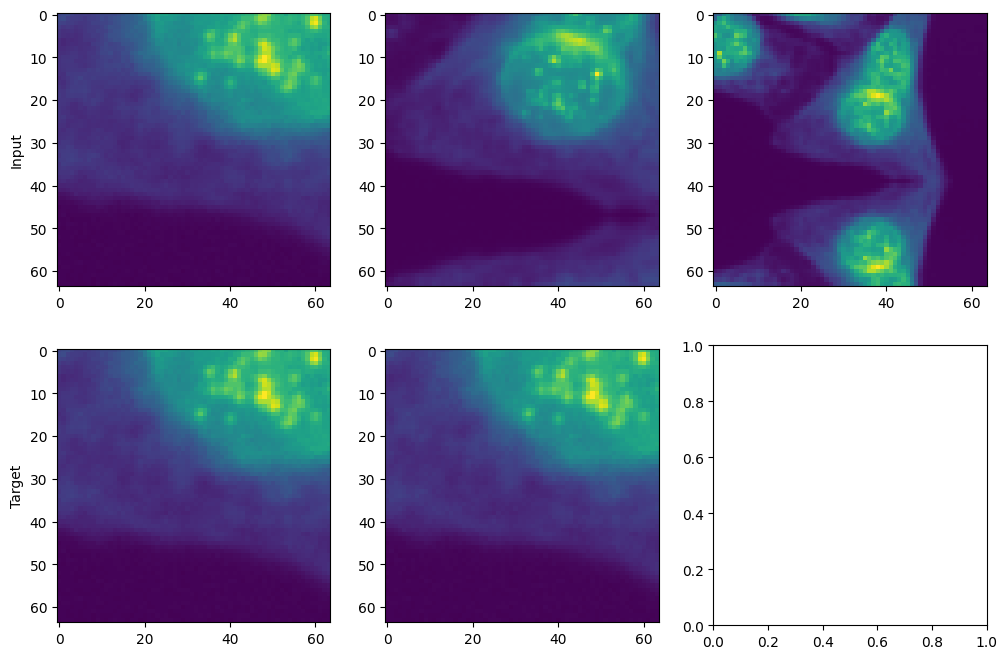

In [15]:
idx = np.random.randint(len(val_dset))
inp_tmp, tar_tmp, *_ = val_dset[idx]
if inp_tmp.ndim == 2:
    inp_tmp = inp_tmp[None,...]

ncols = max(len(inp_tmp),3)
nrows = 2
_,ax = plt.subplots(figsize=(4*ncols,4*nrows),ncols=ncols,nrows=nrows)
for i in range(len(inp_tmp)):
    ax[0,i].imshow(inp_tmp[i])


ax[1,0].imshow(tar_tmp[0])
ax[1,1].imshow(tar_tmp[1])

ax[0,0].set_ylabel('Input')
ax[1,0].set_ylabel('Target')

In [16]:
pred_tiled, rec_loss, logvar, patch_psnr_tuple,predictions_std = get_dset_predictions(model, val_dset,batch_size,
                                               num_workers=num_workers,
                                               mmse_count=mmse_count,
                                                model_type = config.model.model_type,
                                              )

tmp = np.round([x.item() for x in patch_psnr_tuple],2)
print('Patch wise PSNR, as computed during training', tmp,np.mean(tmp) )

100%|██████████| 782/782 [05:41<00:00,  2.29it/s]


Patch wise PSNR, as computed during training [35.78 30.45] 33.115


In [17]:
pred = stitch_predictions(pred_tiled,val_dset )
if 'target_idx_list' in config.data and config.data.target_idx_list is not None and len(config.data.target_idx_list) > pred[0].shape[-1]:
    # it makes it a list. donot make it unless necessary.
    pred = [pred[i][...,:len(config.data.target_idx_list)] for i in range(len(pred))]


## Finding the mixing-ratio

In [18]:
mean_tar = model.data_mean['target'].cpu().numpy()
std_tar = model.data_std['target'].cpu().numpy()
assert mean_tar.shape == (1,2,1,1)
assert mean_tar.shape == std_tar.shape

inp_arr = []
tar_arr = []
for i in tqdm(range(len(val_dset))):
    inp, tar = val_dset[i]
    inp_arr.append(inp[None,:1])
    tar_arr.append((tar - mean_tar)/std_tar)
normalized_inp_patches = np.concatenate(inp_arr,axis=0)
normalized_tar_patches = np.concatenate(tar_arr,axis=0)
del inp_arr, tar_arr
# inp_stitched = stitch_predictions(inp_arr, val_dset)
# inp_stitched = [x[...,0] for x in inp_stitched]
# tar_stitched = stitch_predictions(tar_arr, val_dset)

100%|██████████| 25000/25000 [00:12<00:00, 2042.92it/s]


In [19]:
from finetunesplit.forward_operator_parameters import get_gaussian_sigma, get_best_mixing
from disentangle.core.psnr import RangeInvariantPsnr
tar =  stitch_predictions(normalized_tar_patches, val_dset)
inp =  stitch_predictions(normalized_inp_patches, val_dset)
inp = [x[...,0] for x in inp]

mixing_t_tar,_ = get_best_mixing(tar, inp,RangeInvariantPsnr, plot=False)
mixing_t_pred,_ = get_best_mixing(pred, inp,RangeInvariantPsnr, plot=False)

# Now we need to find the best mu and sigma
# estimated_inp_patches = normalized_tar_patches[:,0]*mixing_t_tar + normalized_tar_patches[:,1]*(1-mixing_t_tar)
estimated_inp_patches = pred_tiled[:,0]*mixing_t_pred + pred_tiled[:,1]*(1-mixing_t_pred)


100%|██████████| 50/50 [00:09<00:00,  5.12it/s]


Best t value: 0.0


100%|██████████| 50/50 [00:09<00:00,  5.12it/s]


Best t value: 0.64


In [20]:
from disentangle.core.psnr import RangeInvariantPsnr
psnr_ch1 = np.mean([RangeInvariantPsnr(tar[i][...,0], pred[i][...,0]) for i in range(len(tar))])
psnr_ch2 = np.mean([RangeInvariantPsnr(tar[i][...,1], pred[i][...,1]) for i in range(len(tar))]) 
print(len(tar))
print(f'PSNR\t{psnr_ch1:.2f} {psnr_ch2:.2f}')

10
PSNR	31.71 28.80


In [21]:
from finetunesplit.forward_operator_parameters import get_forward_operator_parameters
from finetunesplit.posterior_sampler import get_transform_obj, PosteriorSampler, get_input_transform_obj
from finetunesplit.asymmetric_transforms import TransformEnum
from finetunesplit.calibration.calibration_coverage import compute_for_one_batch
from finetunesplit.calibration.grid_search import grid_search
from finetunesplit.calibration.grid_search import plot_coverage_plot
from finetunesplit.calibration.grid_search import get_percentage_occurance

# coverage parameters.
# correlation preserving transform
corr_pres_trans=True
# enable circular padded tranlation transform
enable_translation_transform = False
# we oscillate around the best t with a small delta
delta_t = 0.1
# homography transforms.
aug_theta_max = 0.0
aug_theta_z_max = 0
aug_shift_max=0.0
enable_homography_transform = aug_theta_max > 0 or aug_theta_z_max > 0 or aug_shift_max > 0

# size of the block which is used to compute the correlation
elem_size = 10
mmse_count = 5
# error is computed from the first prediction
compute_error_from_first_prediction= True
k_forward_pass = 2
learn_noise_characteristics = True

k_prediction_mode = 'entire'
# whether to enable the hflip, vflip and 90 degree rotation
with_transforms = False
# apply input transforms to input.
with_inp_transforms = True
keep_original_input_fraction = 0.0
# when disable stochasticity is set to True, we pick the modes from the latent space
# instead of sampling from the distributions. But note that this also means that we get suboptimal prediction as well. To fix this, one may want to have two models.
disable_stochasticity = False

# this ensure that while we fit to 50 percentile, we pick the best fit on the basis of multiple percentiles and so is more robust.
enable_percentile_evaluation = True


In [22]:
if with_transforms:
    ch1_transforms = [(TransformEnum.Rotate,{}),(TransformEnum.HFlip, {}),(TransformEnum.VFlip, {})]
    ch2_transforms = [(TransformEnum.Rotate,{}),(TransformEnum.HFlip, {}),(TransformEnum.VFlip, {})]
else:
    ch1_transforms = [(TransformEnum.Identity, {})]
    ch2_transforms = [(TransformEnum.Identity, {})]

inp_transforms = None
if with_inp_transforms:
    inp_transforms = [(TransformEnum.Rotate,{}),(TransformEnum.HFlip, {}),(TransformEnum.VFlip, {})]

if enable_translation_transform:
    ch1_transforms.append((TransformEnum.Translate, {}))
    ch2_transforms.append((TransformEnum.Translate, {}))

if enable_homography_transform:
    dct = {'theta_max':aug_theta_max, 'theta_z_max':aug_theta_z_max, 'shift_max':aug_shift_max, 'device': 'cuda'}
    print('Enabling homography transform', dct)
    ch1_transforms.append((TransformEnum.DeepInV, dct))
    ch2_transforms.append((TransformEnum.DeepInV, dct))

if enable_percentile_evaluation:
    percentiles_to_evaluate = [10, 20,30,40,50,60,70,80,90]
    print('Enabling percentile evaluation for percentiles:', percentiles_to_evaluate)
else:
    percentiles_to_evaluate = None

Enabling percentile evaluation for percentiles: [10, 20, 30, 40, 50, 60, 70, 80, 90]


In [23]:
from torch import nn
from tqdm import tqdm
from finetunesplit.learn_noise_characteristics import get_noise_parameters
if learn_noise_characteristics:
    noise_params, noise_params_metadata = get_noise_parameters(val_dset, normalized_inp_patches, estimated_inp_patches)
    alpha_dyn = noise_params['alpha_dyn']
    beta_dyn = noise_params['beta_dyn']
    sigma_dyn = noise_params['sigma_dyn']
    alpha_poisson = noise_params['alpha_poisson']
    beta_poisson = noise_params['beta_poisson']
    


loss: 0.004, alpha_dyn: 0.964, beta_dyn: 0.003, sigma_dyn: 0.028, std_loss: 0.000 poisson_loss: 8069.178 alpha_poisson: 3.527 beta_poisson: 0.122: 100%|██████████| 6000/6000 [00:39<00:00, 150.58it/s]

Learned parameters: alpha, beta, sigma 0.9644173383712769 0.0028448428492993116 0.027657730504870415 3.526765823364258 0.12203704565763474


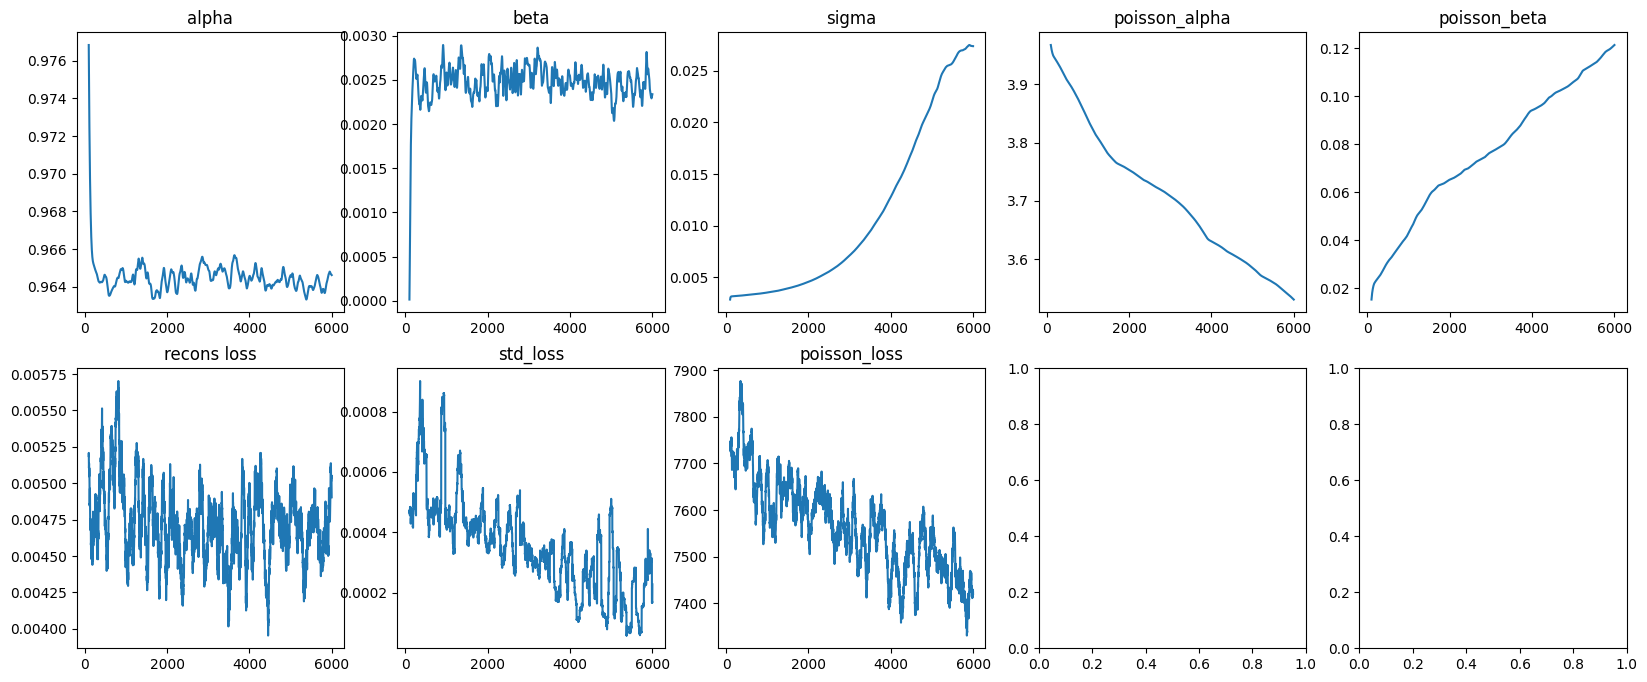

In [24]:
import pandas as pd 
if learn_noise_characteristics:
    alpha_dyn_arr = noise_params_metadata['alpha_dyn_arr']
    beta_dyn_arr = noise_params_metadata['beta_dyn_arr']
    sigma_dyn_arr = noise_params_metadata['sigma_dyn_arr']
    loss_arr = noise_params_metadata['loss_arr']
    std_loss_arr = noise_params_metadata['std_loss_arr']
    poisson_loss_arr = noise_params_metadata['poisson_loss_arr']
    poisson_alpha_dyn_arr = noise_params_metadata['poisson_alpha_dyn_arr']
    poisson_beta_dyn_arr = noise_params_metadata['poisson_beta_dyn_arr']
    
    _,ax = plt.subplots(figsize=(20,8),ncols=5,nrows=2)
    pd.Series(alpha_dyn_arr).rolling(100).mean().plot(ax=ax[0,0], title='alpha')
    pd.Series(beta_dyn_arr).rolling(100).mean().plot(ax=ax[0,1], title='beta')
    pd.Series(sigma_dyn_arr).rolling(100).mean().plot(ax=ax[0,2], title='sigma')
    pd.Series(poisson_alpha_dyn_arr).rolling(100).mean().plot(ax=ax[0,3], title='poisson_alpha')
    pd.Series(poisson_beta_dyn_arr).rolling(100).mean().plot(ax=ax[0,4], title='poisson_beta')


    pd.Series(loss_arr).rolling(100).mean().plot(ax=ax[1,0], title='recons loss')
    pd.Series(std_loss_arr).rolling(100).mean().plot(ax=ax[1,1], title='std_loss')
    pd.Series(poisson_loss_arr).rolling(100).mean().plot(ax=ax[1,2], title='poisson_loss')


2370
618
7879


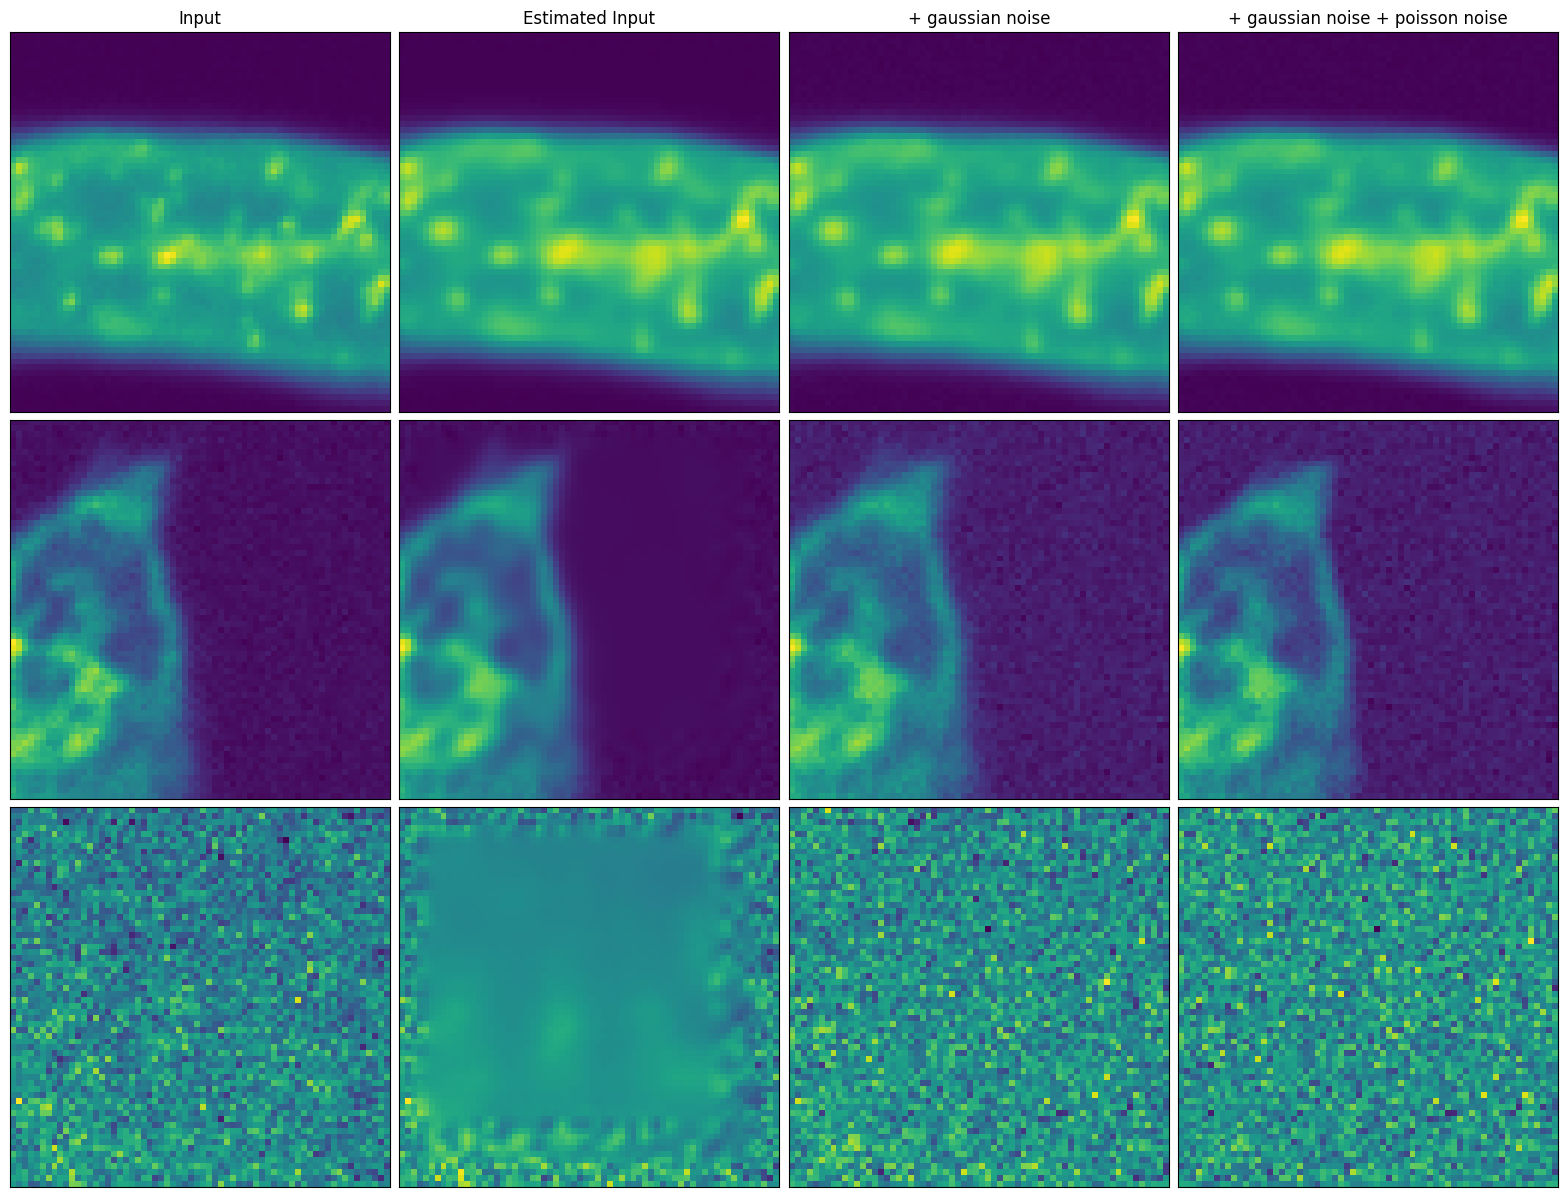

In [25]:
from disentangle.analysis.plot_utils import clean_ax
if learn_noise_characteristics:
    pois_handler = noise_params_metadata['pois_handler']
    
    _,ax = plt.subplots(figsize=(20,15),ncols=4,nrows=3)
    for row_idx in range(3):
        idx = np.random.randint(0,estimated_inp_patches.shape[0])
        print(idx)
        ax[row_idx,0].imshow(normalized_inp_patches[idx,0])
        ax[row_idx,1].imshow(estimated_inp_patches[idx])
        noise_free = estimated_inp_patches[idx]*alpha_dyn + beta_dyn
        gaussian_noise = sigma_dyn*np.random.randn(*estimated_inp_patches[idx].shape)
        with_poisson_noise = pois_handler.add_poisson_noise(torch.Tensor(noise_free)).detach().cpu().numpy()
        ax[row_idx,2].imshow(gaussian_noise + noise_free)
        ax[row_idx, 3].imshow(gaussian_noise + with_poisson_noise)
        
        if row_idx == 0:
            ax[row_idx,0].set_title('Input')
            ax[row_idx,1].set_title('Estimated Input')
            ax[row_idx,2].set_title('+ gaussian noise')
            ax[row_idx,3].set_title('+ gaussian noise + poisson noise')
        
    clean_ax(ax)
    plt.subplots_adjust(wspace=0.02, hspace=0.02)

In [26]:
# from disentangle.analysis.forward_operator_parameters import get_gaussian_sigma, get_best_mixing
input_gaussian_noise_std = None#get_gaussian_sigma(normalized_inp_patches)
poisson_scaling = None
poisson_offset = None
if learn_noise_characteristics:
    # # I have an equation x = alpha * y + beta + sigma * N(0,1)
    mu = beta_dyn
    sigma = alpha_dyn
    input_gaussian_noise_std = sigma_dyn
    mixing_t = mixing_t_pred
    poisson_scaling = alpha_poisson
    poisson_offset = beta_poisson
    # add_poisson_noise(torch.Tensor(noise_free), alpha_poisson.item(), beta_poisson.item(), mean_inp, std_inp).numpy()
else:
    mixing_t, mu, sigma = get_forward_operator_parameters(val_dset, pred_tiled, normalized_inp_patches, input_gaussian_noise_std= input_gaussian_noise_std,plot=True)
forward_operator_params = {
    'mixing_t_min': max(0.1,mixing_t - delta_t),
    'mixing_t_max': min(0.9,mixing_t + delta_t),
    'mu': mu,
    'sigma': sigma,
    'gaussian_noise_std': input_gaussian_noise_std,
    'poisson_handler': pois_handler if learn_noise_characteristics else None,}
print(forward_operator_params)

{'mixing_t_min': np.float64(0.54), 'mixing_t_max': np.float64(0.74), 'mu': 0.0028448428492993116, 'sigma': 0.9644173383712769, 'gaussian_noise_std': 0.027657730504870415, 'poisson_handler': <finetunesplit.posterior_sampler.PoissonNoiseHander object at 0x7fb10f7f4ad0>}


In [27]:
nTar = pred[0].shape[-1]
is_list_prediction = isinstance(pred, list)
tar_unnorm = (val_dset._data if not is_list_prediction else [val_dset.dsets[i]._data for i in range(len(val_dset.dsets))])

if "target_idx_list" in config.data and config.data.target_idx_list is not None:
    nTar =len(config.data.target_idx_list)

if 'input_idx' in config.data and config.data.input_idx is not None:
    inp_unnorm = [x[...,config.data.input_idx] for x in tar_unnorm] if is_list_prediction else tar_unnorm[...,config.data.input_idx]
    tar_unnorm = [x[...,:nTar] for x in tar_unnorm] if is_list_prediction else tar_unnorm[...,:nTar]
else:
    inp_unnorm = [x.mean(axis=-1) for x in tar_unnorm]


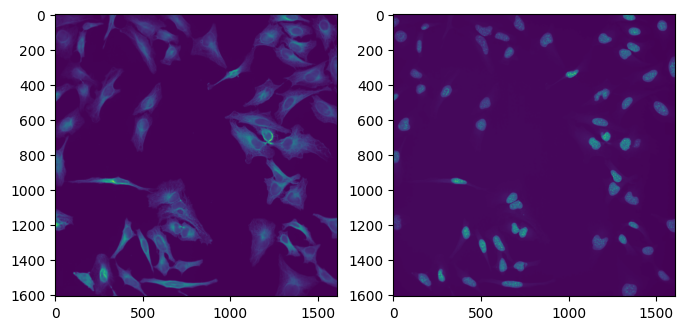

In [28]:
_,ax = plt.subplots(figsize=(8,4),ncols=2)
if is_list_prediction:
    ax[0].imshow(pred[0][0,...,0])
    ax[1].imshow(pred[0][0,...,1])
else:
    ax[0].imshow(pred[0,...,0])
    ax[1].imshow(pred[0,...,1])

### A model to yield augmented predictions.

In [29]:
import torch.nn as nn 
class NnModel(nn.Module):
    def __init__(self, model):
        super(NnModel, self).__init__()
        self.model = model
    
    def forward(self, x):
        return self.model(x)[0]

singleoutput_model = NnModel(model).cuda()

In [30]:
pred_transform_obj = get_transform_obj(ch1_transforms, ch2_transforms, correlation_preserving_transforms=corr_pres_trans)
print('')
print('')
inp_transform_obj = get_input_transform_obj(inp_transforms) if with_inp_transforms else None


Transforms for Ch1: [('identity', {})]
Transforms for Ch2: [('identity', {})]
Using correlation preserving transforms
Using transform types: {0: [Identity(transform_type='identity')], 1: [Identity(transform_type='identity')]}


Transforms for Ch1: [('rotate', {}), ('hflip', {}), ('vflip', {})]
Transforms for Ch2: [('rotate', {}), ('hflip', {}), ('vflip', {})]
Using correlation preserving transforms
Using transform types: {0: [Rotate(transform_type='rotate'), HFlip(transform_type='hflip'), VFlip(transform_type='vflip')], 1: [Rotate(transform_type='rotate'), HFlip(transform_type='hflip'), VFlip(transform_type='vflip')]}


In [35]:
inp_transforms

[('rotate', {}), ('hflip', {}), ('vflip', {})]

In [31]:
aug_model = PosteriorSampler(singleoutput_model, pred_transform_obj, forward_operator_params=forward_operator_params, mmse_count=mmse_count,
                                        k_forward_pass=k_forward_pass, input_transforms=inp_transform_obj, keep_original_input_fraction=keep_original_input_fraction)

[PosteriorSampler] k_forward_pass: 2
[PosteriorSampler] mixing_t range: [0.54, 0.74], mu: 0.0028448428492993116, sigma: 0.9644173383712769, gaussian_noise_std: 0.027657730504870415
[PosteriorSampler] Input transforms enabled


In [33]:
inp_b.shape

torch.Size([5, 3, 64, 64])

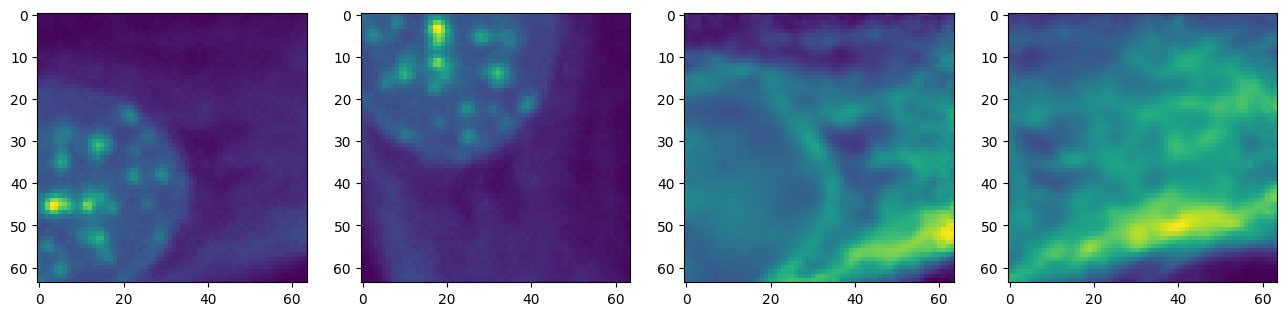

In [37]:
if inp_transform_obj is not None:
    dloader = DataLoader(val_dset, batch_size=5, shuffle=False, num_workers=0)
    for batch in dloader:
        inp_b, tar_b = batch
        break
    
    with torch.no_grad():   
        pred, applied_transforms, inp_transformed = aug_model.one_forward_pass_inp(inp_b.cuda())

    _,ax = plt.subplots(figsize=(16,4),ncols=4)
    ax[0].imshow(inp_b[0,0])
    ax[1].imshow(inp_transformed[0,0].cpu())
    ax[2].imshow(pred[0,0].cpu())
    ax[3].imshow(pred[1,0].cpu())

In [39]:
idx_list = np.where(logvar.squeeze() < -6)[0]
if len(idx_list) > 0:
    plt.imshow(val_dset[idx_list[0]][1][1])

In [40]:
pred = stitch_predictions(pred_tiled,val_dset)

In [41]:
def print_ignored_pixels():
    ignored_pixels = 1
    while(pred[0,-ignored_pixels:,-ignored_pixels:,].std() ==0):
        ignored_pixels+=1
    ignored_pixels-=1
    print(f'In {pred.shape}, last {ignored_pixels} many rows and columns are all zero.')
    return ignored_pixels

ignored_pixels_in_data = print_ignored_pixels()

In (10, 1608, 1608, 2), last 0 many rows and columns are all zero.


## Ignore the pixels which are present in the last few rows and columns. 
1. They don't come in the batches. So, in prediction, they are simply zeros. So they are being are ignored right now.

In [42]:
ignored_pixels_in_data

0

In [43]:
ignore_last_pixels_count = 32 if config.data.data_type == DataType.OptiMEM100_014 else ignored_pixels_in_data

assert ignored_pixels_in_data <= ignore_last_pixels_count, f'Set ignore_last_pixels_count={ignored_pixels_in_data}'
print(ignore_last_pixels_count)

0


In [44]:
tar = val_dset._data_original[...,:-1]
if config.data.data_type == DataType.SeparateTiffData:
    tar[ tar > MAX_VAL] = MAX_VAL

def ignore_pixels(arr):
    if ignore_last_pixels_count:
        arr = arr[:,:-ignore_last_pixels_count,:-ignore_last_pixels_count]
    return arr

pred = ignore_pixels(pred)
tar = ignore_pixels(tar)


In [45]:
from skimage.metrics import structural_similarity

def _avg_psnr(target, prediction, psnr_fn):
    output = np.mean([psnr_fn(target[i:i + 1], prediction[i:i + 1]).item() for i in range(len(prediction))])
    return round(output, 2)


def avg_range_inv_psnr(target, prediction):
    return _avg_psnr(target, prediction, RangeInvariantPsnr)


def avg_psnr(target, prediction):
    return _avg_psnr(target, prediction, PSNR)


def compute_masked_psnr(mask, tar1, tar2, pred1, pred2):
    mask = mask.astype(bool)
    mask = mask[..., 0]
    tmp_tar1 = tar1[mask].reshape((len(tar1), -1, 1))
    tmp_pred1 = pred1[mask].reshape((len(tar1), -1, 1))
    tmp_tar2 = tar2[mask].reshape((len(tar2), -1, 1))
    tmp_pred2 = pred2[mask].reshape((len(tar2), -1, 1))
    psnr1 = avg_range_inv_psnr(tmp_tar1, tmp_pred1)
    psnr2 = avg_range_inv_psnr(tmp_tar2, tmp_pred2)
    return psnr1, psnr2

def avg_ssim(target, prediction):
    ssim = [structural_similarity(target[i],prediction[i], data_range=(target[i].max() - target[i].min())) for i in range(len(target))]
    return np.mean(ssim),np.std(ssim)

In [46]:
if config.data.data_type == DataType.SeparateTiffData:
    sep_mean = np.array([[[[237.37582]],[[237.37582]]]])
    sep_std = np.array([[[[299.02316]],[[299.02316]]]])
elif config.data.data_type in [DataType.indiSplit_HTLIF24]:
    sep_mean = np.array([[[[411.70557]],[[349.42032]]]])
    sep_std = np.array([[[[630.8665]],[[327.70892]]]])
elif config.data.data_type in [DataType.TavernaSox2GolgiV2, DataType.indiSplit_HTT24]:
    sep_mean = np.array([[[[247.25721281]],[[333.98826175]]]])
    sep_std = np.array([[[[135.71459324]],[[257.38415285]]]])
elif config.data.data_type in [DataType.CosemHela]:
    sep_mean, sep_std = train_dset.get_mean_std()
else:
    raise NotImplementedError(config.data.data_type)

In [47]:
# sep_mean, sep_std = model.data_mean, model.data_std
if isinstance(sep_mean, dict):
    sep_mean = sep_mean['target']
    sep_std = sep_std['target']
    
sep_mean = sep_mean.squeeze()[None,None,None]
sep_std = sep_std.squeeze()[None,None,None]

tar_normalized = (tar - sep_mean)/sep_std
tar1 =tar_normalized[...,0]
tar2 =tar_normalized[...,1]

3


(10, 1608, 1608, 2)

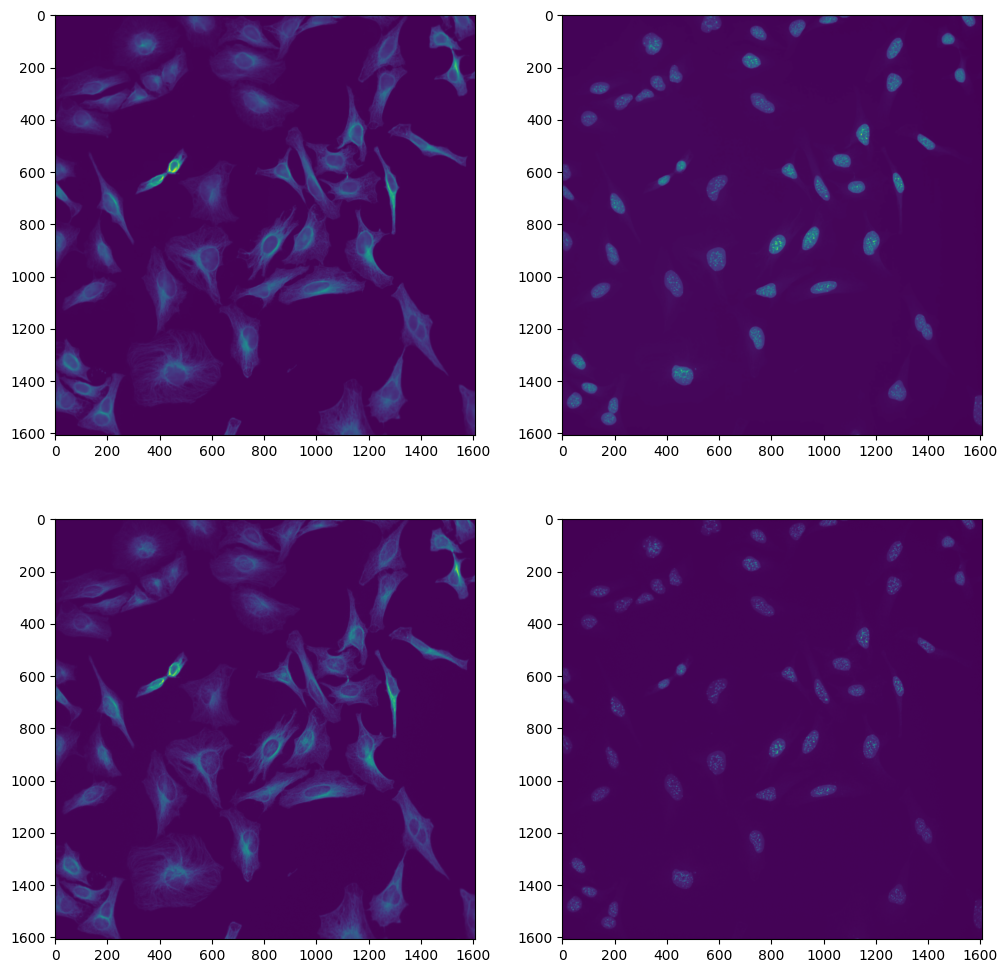

In [48]:
_,ax = plt.subplots(figsize=(12,12),ncols=2,nrows=2)
idx = np.random.randint(len(pred))
print(idx)
ax[0,0].imshow(pred[idx,:,:,0])
ax[0,1].imshow(pred[idx,:,:,1])
ax[1,0].imshow(tar1[idx,:,:])
ax[1,1].imshow(tar2[idx,:,:])

pred.shape

In [49]:
pred1, pred2 = pred[...,0].astype(np.float32), pred[...,1].astype(np.float32)
rmse1 =np.sqrt(((pred1 - tar1)**2).reshape(len(pred1),-1).mean(axis=1))
rmse2 =np.sqrt(((pred2 - tar2)**2).reshape(len(pred2),-1).mean(axis=1)) 

rmse = (rmse1 + rmse2)/2
rmse = np.round(rmse,3)
psnr1 = avg_psnr(tar1, pred1) 
psnr2 = avg_psnr(tar2, pred2)
rinv_psnr1 = avg_range_inv_psnr(tar1, pred1)
rinv_psnr2 = avg_range_inv_psnr(tar2, pred2)
ssim1_mean, ssim1_std = avg_ssim(tar1, pred1)
ssim2_mean, ssim2_std = avg_ssim(tar2, pred2)

In [50]:
print(f' {DataSplitType.name(eval_datasplit_type)}_P{custom_image_size}_G{image_size_for_grid_centers}_M{mmse_count}_Sk{ignore_last_pixels_count}')
print('Rec Loss',np.round(rec_loss.mean(),3) )
print('RMSE', np.mean(rmse1).round(3), np.mean(rmse2).round(3), np.mean(rmse).round(3))
print('[Paper] RangeInv PSNR',rinv_psnr1, rinv_psnr2 )
print('[Paper] SSIM',round(ssim1_mean,3), round(ssim2_mean,3),'±',round((ssim1_std + ssim2_std)/2,4))
print()

 Test_P64_G32_M5_Sk0
Rec Loss 4.53
RMSE 0.353 0.528 0.44
[Paper] RangeInv PSNR 39.19 40.88
[Paper] SSIM 0.934 0.854 ± 0.041



In [51]:
print(sep_mean.shape, sep_std.shape)
pred_unnormalized = pred * sep_std + sep_mean


(1, 1, 1, 2) (1, 1, 1, 2)


In [ ]:
from disentangle.core.metrics import compute_stats
stats_dict = compute_stats(tar, pred_unnormalized)


In [ ]:
from skimage.io import imread, imsave
def save_tiff(path, data):
    imsave(path, data, plugin='tifffile')

pred_unnormalized.shape
param_str = f"MMSE-{mmse_count}_RealInput"
ckpt_str = 'MicroSplit_' + '_'.join(ckpt_dir.split('/')[-3:])
result_dir = os.path.join('/group/jug/ashesh/indiSplit/', 'prediction_baselines',ckpt_str + '_' + param_str)
os.makedirs(result_dir, exist_ok=True)
print(result_dir)



save_tiff(os.path.join(result_dir,'pred.tif'), pred_unnormalized)
# save_tiff(os.path.join(result_dir,'dim_pred.tif'), pred_dim_pred_stitched)
# pred_bt_removed_stitched.shape, pred_bt_removed_stitched.shape